# Simulating lattice gauge theory with Rydberg atoms

In this example notebook, we will simulate a lattice gauge theory (LGD) with the Rydberg atoms

## Introduction 


## Adiabatic evolution

We begin by importing the necessary packages.

In [1]:
# # # Run the following command in the terminal to install necessary dependencies (seems like need to install in this order to work properly)
# # #
# ! pip install git+ssh://git@github.com/aws/amazon-braket-schemas-python.git@quera 
# ! pip install git+ssh://git@github.com/aws/amazon-braket-sdk-python.git@feature/ahs
# ! pip install git+ssh://git@github.com/aws/amazon-braket-default-simulator-python-staging.git@feature/neutral-atom-simulator-solvers


In [2]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement


from braket.ahs.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field
from braket.ahs.pattern import Pattern
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, show_drive_and_shift, get_avg_density

from braket.analog_hamiltonian_simulator.rydberg.rydberg_simulator import RydbergAtomSimulator

## Preparign the initial state for the LGT dynamics

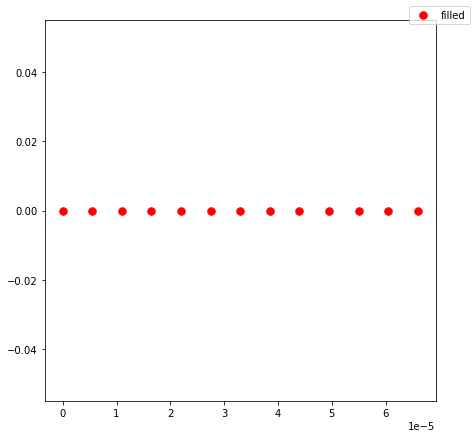

In [3]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 13 # 4n+1

for k in range(num_atoms):
    register.add((k*separation, 0))
    
show_register(register)

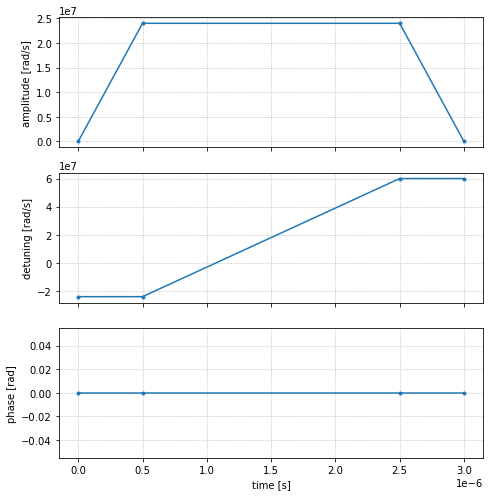

In [4]:
# Build the time values for the driving fields
duration = 3e-6
time_ramp = 5e-7
times = [0, time_ramp, duration-time_ramp, duration]


# build the waveform for the amplitude
amplitude_min = 0       
amplitude_max = 24e6
values_amplitude = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
amplitude = TimeSeries()
for t, v in zip(times, values_amplitude):
    amplitude.put(t, v)

# build the waveform for the detuning
detuning_min = -24e6
detuning_max = 60e6
values_detuning = [detuning_min, detuning_min, detuning_max, detuning_max]
detuning = TimeSeries()
for t, v in zip(times, values_detuning):
    detuning.put(t, v)

# build the waveform for the phase
values_phase = [0, 0, 0, 0]
phase = TimeSeries()
for t, v in zip(times, values_phase):
    phase.put(t, v)

drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)
show_global_drive(drive)

The input program is being validated.

10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.10s. Est. time left: 00:00:00:00
30.0%. Run time:   0.18s. Est. time left: 00:00:00:00
40.0%. Run time:   0.28s. Est. time left: 00:00:00:00
50.0%. Run time:   0.38s. Est. time left: 00:00:00:00
60.0%. Run time:   0.49s. Est. time left: 00:00:00:00
70.0%. Run time:   0.61s. Est. time left: 00:00:00:00
80.0%. Run time:   0.75s. Est. time left: 00:00:00:00
90.0%. Run time:   0.91s. Est. time left: 00:00:00:00
Total run time:   1.04s


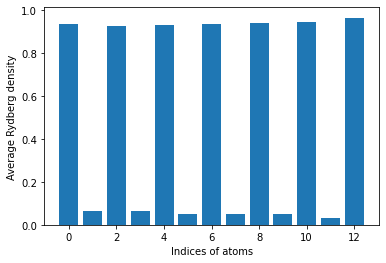

In [5]:
hamiltonian = Hamiltonian()
hamiltonian += drive

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian
)

ahs_program_ir = ahs_program.to_ir()

device = RydbergAtomSimulator()
result = device.run(ahs_program_ir, blockade_radius=separation, progress_bar=True)
show_final_avg_density(result)

## $Z_2$ order phase with a defect

In [6]:
# Build the time values for the driving and shifting fields
shift_value = -1.5*detuning_max
max_shift_slew_rate = 1250000000000000
time_ramp_shift = abs(shift_value)/max_shift_slew_rate

max_amplitude_slew_rate = 2.5e14
time_ramp_down_amplitude = (amplitude_max-amplitude_min)/max_amplitude_slew_rate

times_defect = [*times[:-1], 
                times[-2]+time_ramp_shift, 
                times[-2]+time_ramp_shift+time_ramp_down_amplitude
               ]

# build the waveform for the amplitude
values_amplitude_defect = [*values_amplitude[:-1], amplitude_max, amplitude_min]
amplitude = TimeSeries()
for t, v in zip(times_defect, values_amplitude_defect):
    amplitude.put(t, v)

# build the waveform for the detuning
values_detuning_defect = [*values_detuning[:-1], detuning_max, detuning_max]
detuning = TimeSeries()
for t, v in zip(times_defect, values_detuning_defect):
    detuning.put(t, v)

# build the waveform for the phase
values_phase_defect = [*values_phase[:-1], 0, 0]
phase = TimeSeries()
for t, v in zip(times_defect, values_phase_defect):
    phase.put(t, v)

drive = DrivingField(
    amplitude=amplitude, 
    detuning=detuning, 
    phase=phase
)        

[0, 5e-07, 2.5e-06, 3e-06]
[0, 5e-07, 2.5e-06, 2.572e-06, 2.668e-06]


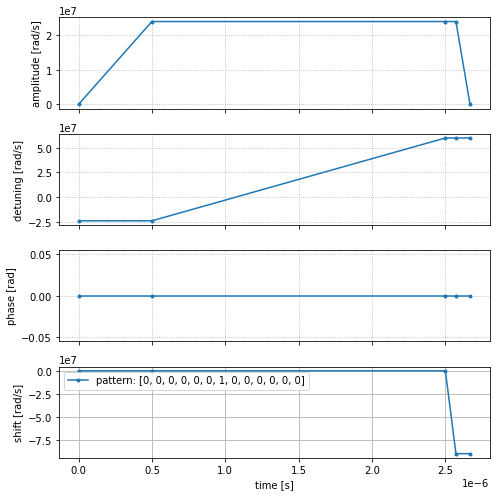

In [7]:
values_magnitude = [*[0 for _ in range(len(times[:-1]))], 
                    shift_value, 
                    shift_value
                   ]

magnitude = TimeSeries()
for t, v in zip(times_defect, values_magnitude):
    magnitude.put(t, v)
    
pattern_defect = [1 if idx==int(num_atoms/2) else 0 for idx in range(num_atoms)]
shift = ShiftingField(Field(time_series=magnitude, pattern=Pattern(pattern_defect)))

print(times)
print(times_defect)

show_drive_and_shift(drive, shift)        

The input program is being validated.



/Users/maolinml/opt/anaconda3/lib/python3.9/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:12: UserWarning: Value 3 (-90000000.0) in magnitude sequence outside the typical range [0, 125000000.0]. The values should be specified in SI units.
  warnings.warn(


10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.16s. Est. time left: 00:00:00:00
30.0%. Run time:   0.28s. Est. time left: 00:00:00:00
40.0%. Run time:   0.43s. Est. time left: 00:00:00:00
50.0%. Run time:   0.58s. Est. time left: 00:00:00:00
60.0%. Run time:   0.75s. Est. time left: 00:00:00:00
70.0%. Run time:   0.92s. Est. time left: 00:00:00:00
80.0%. Run time:   1.14s. Est. time left: 00:00:00:00
90.0%. Run time:   1.36s. Est. time left: 00:00:00:00
Total run time:   1.55s


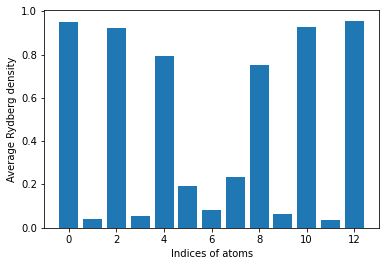

In [8]:
hamiltonian_defect = Hamiltonian()
hamiltonian_defect += drive 
hamiltonian_defect += shift

ahs_program_with_defect = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=hamiltonian_defect
)

ahs_program_with_defect_ir = ahs_program_with_defect.to_ir()

result = device.run(ahs_program_with_defect_ir, blockade_radius=separation, progress_bar=True)

show_final_avg_density(result)

## Propagation of particle-antiparticle pairs

In [9]:
max_detuning_slew_rate = 2.5e15
max_duration=4e-6, 
max_amplitude_slew_rate = 2.5e14
detuning_propagation = -pi * 1e6
time_ramp_detuning = abs(detuning_propagation-detuning_max)/max_detuning_slew_rate
time_ramp_amplitude = (amplitude_max-amplitude_min)/max_amplitude_slew_rate

In [10]:
def get_program_propagation(
    time_propagation,
    max_duration=4e-6, 
    max_amplitude_slew_rate = 2.5e14, 
    detuning_propagation = -pi * 1e6, 
    max_detuning_slew_rate = 2.5e15
):
    # Build the time values for the amplitude and phase
    time_ramp_amplitude = (amplitude_max-amplitude_min)/max_amplitude_slew_rate

    times_propagation_amplitude = times_defect + [
        times_defect[-1] + time_ramp_amplitude,
        times_defect[-1] + time_propagation,
        times_defect[-1] + time_propagation + time_ramp_amplitude
    ]

    # build the waveform for the amplitude
    values_amplitude_propagation = values_amplitude_defect + [
        amplitude_max, 
        amplitude_max, 
        amplitude_min
    ]
    amplitude = TimeSeries()
    for t, v in zip(times_propagation_amplitude, values_amplitude_propagation):
        amplitude.put(t, v)

    # build the waveform for the phase
    values_phase_propagation = values_phase_defect + [0, 0, 0]
    phase = TimeSeries()
    for t, v in zip(times_propagation_amplitude, values_phase_propagation):
        phase.put(t, v)


    # Build the time values for the detuning

    time_ramp_detuning = abs(detuning_propagation-detuning_max)/max_detuning_slew_rate

    times_propagation_detuning = times_defect + [
        times_defect[-1] + time_ramp_detuning,
        times_propagation_amplitude[-1]
    ]


    # build the waveform for the detuning
    values_detuning_propagation = values_detuning_defect + [
        detuning_propagation,
        detuning_propagation
    ]

    detuning = TimeSeries()
    for t, v in zip(times_propagation_detuning, values_detuning_propagation):
        detuning.put(t, v)



    drive = DrivingField(
        amplitude=amplitude, 
        detuning=detuning, 
        phase=phase
    )


    # Build the time values for the shifting fields
    times_propagation_shift = times_defect + [
        times_defect[-1] + time_ramp_shift, 
        times_propagation_amplitude[-1]
    ]

    values_magnitude_propagation = values_magnitude + [0, 0]

    magnitude = TimeSeries()
    for t, v in zip(times_propagation_shift, values_magnitude_propagation):
        magnitude.put(t, v)

    shift = ShiftingField(Field(time_series=magnitude, pattern=Pattern(pattern_defect)))

    hamiltonian_propagation = Hamiltonian()
    hamiltonian_propagation += drive 
    hamiltonian_propagation += shift

    ahs_program_propagation = AnalogHamiltonianSimulation(
        register=register, 
        hamiltonian=hamiltonian_propagation
    )
    return drive, shift, ahs_program_propagation
    
    

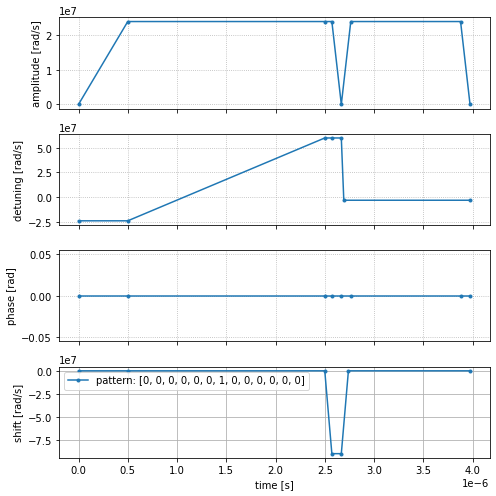

In [11]:
max_duration = 4e-6
max_time_propagation = max_duration - times_defect[-1] - time_ramp_detuning - time_ramp_amplitude

drive, shift, _ = get_program_propagation(max_time_propagation)
show_drive_and_shift(drive, shift)

In [12]:
def get_average_densities_propagation(max_time_propagation, time_steps=100, simulation_steps=100):
    time_propagation_list = np.linspace(0, max_time_propagation, num=time_steps)
    
    ahs_program_propagation_list = [get_program_propagation(time_propagation)[2] for time_propagation in time_propagation_list]
    
    result_list = [device.run(ahs_program_propagation.to_ir(), blockade_radius=separation, steps=simulation_steps) for ahs_program_propagation in ahs_program_propagation_list]
    
    average_densities = [get_avg_density(result) for result in result_list]
    
    return average_densities
        

In [13]:
densities = get_average_densities_propagation(max_time_propagation)

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is being validated.

The input program is bein

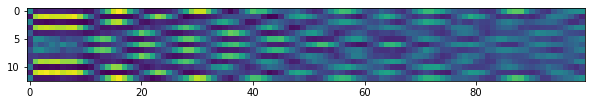

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(densities))